In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Set the color map to grayscale
plt.set_cmap('gray')

# Train on GPU to speed up training if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<Figure size 640x480 with 0 Axes>

# Load and preprocess dataset

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MNISTImages(Dataset):
    def __init__(self, root, download=True, transform=None):
        self.dataset = MNIST(root, download=download)
        self.transform = transform

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.dataset)

# Convert to tensor and then normalize our images to -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNISTImages('./', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Creating the denoising UNet
<img src="images/unet_architecture.png" width="50%" style="display: block; margin: auto;">

In [3]:
def samePadding(kernel_size):
    return kernel_size // 2 if isinstance(kernel_size, int) else [x // 2 for x in kernel_size]

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=None, activation=True):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding or samePadding(kernel_size), bias=False)
        self.batchNorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU() if activation is True else activation if isinstance(activation, nn.Module) else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchNorm(x)
        x = self.activation(x)
        return x

class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0, batchnorm=True, activation=True):
        super().__init__()
        
        self.convTranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not batchnorm)
        self.batchNorm = nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity()
        self.activation = nn.ReLU() if activation is True else activation if isinstance(activation, nn.Module) else nn.Identity()
    
    def forward(self, x):
        x = self.convTranspose(x)
        x = self.batchNorm(x)
        x = self.activation(x)
        return x

In [4]:
class Downconv(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim):
        super().__init__()

        self.t_emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )

        self.conv1 = Conv(in_channels, out_channels, kernel_size=3)
        self.conv2 = Conv(out_channels, out_channels, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x, t_emb):
        t = self.t_emb_layer(t_emb)[:, :, None, None]

        x = self.conv1(x)
        x = x + t
        x = self.conv2(x)
        return self.pool(x), x

class Upconv(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim):
        super().__init__()

        self.t_emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )

        self.upconv = ConvTranspose(in_channels, out_channels)
        self.conv1 = Conv(in_channels, out_channels, kernel_size=3)
        self.conv2 = Conv(out_channels, out_channels, kernel_size=3)
    
    def forward(self, prev, x, t_emb):
        t = self.t_emb_layer(t_emb)[:, :, None, None]

        x = self.upconv(x)

        x = x + t
        x = torch.concat([prev, x], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)

        return x

In [5]:
import numpy as np

def get_time_embedding(time_steps, temb_dim):
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class UNet(nn.Module):
    def __init__(self, timesteps=100, t_emb_dim=16, blocks=2, channels=32):
        super().__init__()

        self.t_emb_dim = t_emb_dim
        self.t_proj = nn.Sequential(
            nn.Linear(t_emb_dim, t_emb_dim),
            nn.SiLU(),
            nn.Linear(t_emb_dim, t_emb_dim)
        )

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        self.encoder.append(Downconv(1, channels, t_emb_dim=t_emb_dim))
        for _ in range(blocks - 1):
            self.encoder.append(Downconv(channels, channels * 2, t_emb_dim=t_emb_dim))
            channels *= 2
        
        self.bottleneck = nn.Sequential(
            Conv(channels, channels*2),
            Conv(channels*2, channels*2),
        )

        channels *= 2
        for _ in range(blocks):
            self.decoder.append(Upconv(channels, channels // 2, t_emb_dim=t_emb_dim))
            channels //= 2
        
        self.conv = Conv(channels, 1, 1, activation=False)
    
    def forward(self, x, t):
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        skips = []
        for down in self.encoder:
            x, skip = down(x, t_emb)
            skips.append(skip)

        x = self.bottleneck(x)

        for up, skip in zip(self.decoder, reversed(skips)):
            x = up(skip, x, t_emb)
        
        return self.conv(x)

In [6]:
from torchinfo import summary

model = UNet()

# Generate model summary to ensure that the input and output shapes are the exact same
summary(model, 
    input_data=[torch.zeros(1, 1, 28, 28), torch.tensor([1])], 
    col_names=["input_size", "output_size", "num_params", "kernel_size"], 
    depth=5
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape
UNet                                          [1, 1, 28, 28]            [1, 1, 28, 28]            --                        --
├─Sequential: 1-1                             [1, 16]                   [1, 16]                   --                        --
│    └─Linear: 2-1                            [1, 16]                   [1, 16]                   272                       --
│    └─SiLU: 2-2                              [1, 16]                   [1, 16]                   --                        --
│    └─Linear: 2-3                            [1, 16]                   [1, 16]                   272                       --
├─ModuleList: 1-2                             --                        --                        --                        --
│    └─Downconv: 2-4                          [1, 1, 28, 28]            [1, 32, 14, 14]           -- 

In [36]:
from schedules import CosineSchedule

STEPS = 50
schedule = CosineSchedule(T=STEPS, s=0.008)

alpha_bar = schedule.alpha_bar
beta = schedule.beta
alpha = schedule.alpha

e:\Users\Jason\Code\Deep Learning\_PyTorch\mnist\diffusion\schedules.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


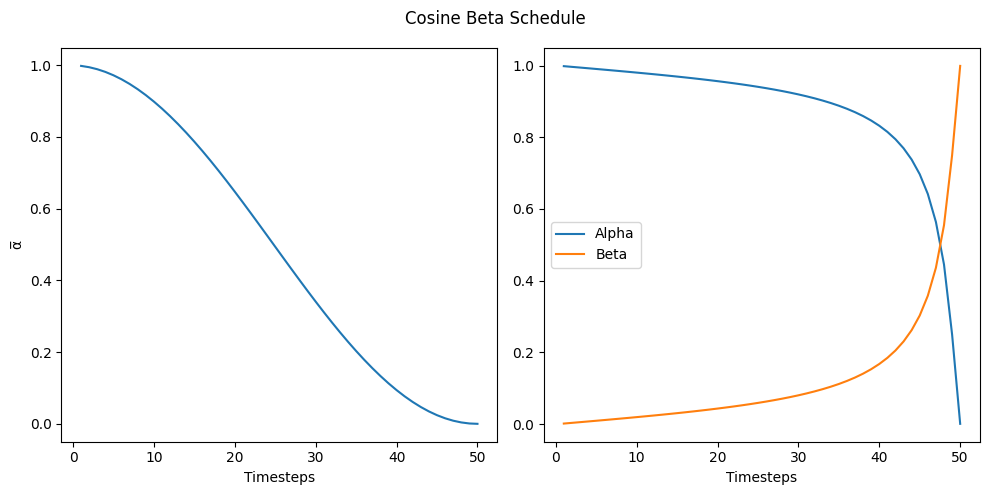

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(torch.arange(1, STEPS+1), alpha_bar)
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('α̅')

axes[1].plot(torch.arange(1, STEPS+1), alpha, label='Alpha')
axes[1].plot(torch.arange(1, STEPS+1), beta, label='Beta')
axes[1].set_xlabel('Timesteps')
axes[1].legend()

plt.suptitle('Cosine Beta Schedule')
plt.tight_layout()
plt.show()

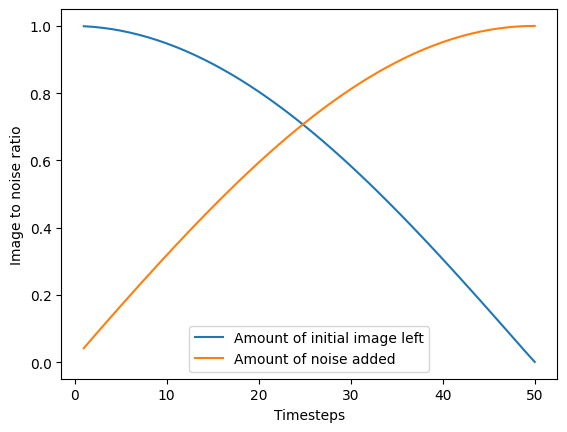

In [9]:
plt.plot(torch.arange(1, STEPS+1), torch.sqrt(alpha_bar), label='Amount of initial image left')
plt.plot(torch.arange(1, STEPS+1), torch.sqrt(1 - alpha_bar), label='Amount of noise added')
plt.xlabel('Timesteps')
plt.ylabel('Image to noise ratio')
plt.legend()
plt.show()

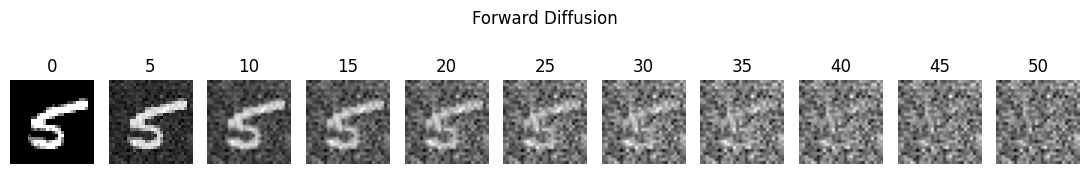

In [ ]:
n = 10
fig, axes = plt.subplots(1, n+1, figsize=(n+1, 2))

img = next(iter(dataloader))[:1]
noise = torch.randn_like(img.squeeze())

for t, ax in enumerate(axes):
    timestep = int(STEPS / n * t)

    ax.axis(False)
    ax.set_title(timestep)
    if timestep == 0:
        # t=0 refers to the original image without any noise added
        ax.imshow(img.squeeze())
        continue

    ax.imshow(np.sqrt(alpha_bar[timestep-1]) * img.squeeze() + np.sqrt(1 - alpha_bar[timestep-1]) * noise)

plt.suptitle('Forward Diffusion')
plt.tight_layout()
plt.show()

# Training
<img src="images/training.jpg" width="50%" style="display: block; margin: auto;">

In [11]:
from tqdm import tqdm
from torch.optim import Adam, Optimizer
from torch.nn import MSELoss

def train(model, dataloader, optimizer: Optimizer, criterion: nn.Module):
    model.train()

    total_samples = 0
    total_loss = 0

    pbar = tqdm(dataloader)
    for img in pbar:
        img = img.to(device)
        optimizer.zero_grad()  # Reset gradients to 0 at the start of each batch, so it does not carry over 

        batch_size = img.size(0)

        t = torch.randint(0, STEPS, size=(batch_size,)).to(device)
        noise = torch.randn_like(img).to(device)  # Label to be predicted

        # Reshape our timestep so that it can be broadcasted for multiplication
        t_reshaped = t.reshape(-1, 1, 1, 1)
        noised_img = torch.sqrt(alpha_bar[t_reshaped]) * img + torch.sqrt(1 - alpha_bar[t_reshaped]) * noise
        predicted_noise = model(noised_img, t)

        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_samples += batch_size
        total_loss += loss.item() * batch_size

        pbar.set_postfix(loss=total_loss / total_samples)

In [26]:
EPOCHS = 100
model = UNet(timesteps=STEPS, t_emb_dim=32)
model.to(device)

optimizer = Adam(model.parameters(), lr=5e-4)
criterion = MSELoss()

alpha = schedule.alpha.to(device)
beta = schedule.beta.to(device)
alpha_bar = schedule.alpha_bar.to(device)

for e in range(EPOCHS):
    train(model, dataloader, optimizer, criterion)

100%|██████████| 469/469 [00:11<00:00, 39.96it/s, loss=0.0373]


# Generating new images
<img src="images/sampling.png" width="50%" style="display: block; margin: auto;">

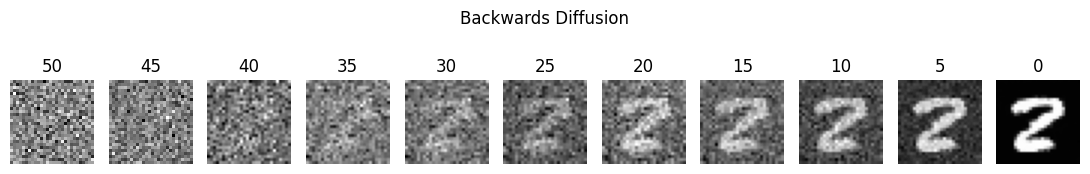

In [33]:
n = 10
fig, axes = plt.subplots(1, n+1, figsize=(n+1, 2))
model.eval()

with torch.no_grad():
    x = torch.randn(size=(1, 1, 28, 28)).to(device)
    reverse_diffusion = [x.cpu()]
    for t in reversed(range(STEPS)):
        sigma = torch.sqrt(beta[t])
        z = torch.randn(size=(1, 1, 28, 28)).to(device) if t > 1 else 0

        predicted_noise = model(x, torch.tensor([t]).to(device))

        x = (1 / torch.sqrt(alpha[t])) * (x - (1 - alpha[t])/(torch.sqrt(1 - alpha_bar[t])) * predicted_noise) + sigma * z
        reverse_diffusion.append(x.cpu())

for t, ax in enumerate(axes):
    timestep = int(STEPS / n * t)

    ax.axis(False)
    ax.set_title(STEPS - timestep)
    ax.imshow(reverse_diffusion[timestep].squeeze())

plt.suptitle('Backwards Diffusion')
plt.tight_layout()
plt.show()

In [ ]:
# Save latest model, trained for 20 minutes on a RTX 3060ti
# torch.save(model.state_dict(), 'Diffusion_EPOCH100_S50_L0.0373.pt')

In [ ]:
# Load saved model
# STEPS = 50
# model = UNet(timesteps=STEPS, t_emb_dim=32)
# model.load_state_dict(torch.load('Diffusion_EPOCH100_S50_L0.0373.pt'))

<All keys matched successfully>